In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [25]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


In [26]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
mean = layers.Dense(latent_dim, name='mean')(x)
log_var = layers.Dense(latent_dim, name='log_var')(x)
z = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │        640 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6272)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │    100,368 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         34 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 2)         │         34 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ mean[0][0],       │
│ (Sampling)          │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

defining decoder block 

In [27]:
latent_inputs=keras.Input(shape=(latent_dim,))
x=layers.Dense(7*7*64,activation="relu")(latent_inputs)
x=layers.Reshape((7,7,64))(x)
x=layers.Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(x)
x=layers.Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(x)
decoder_outputs=layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")(x)
decoder=keras.Model(latent_inputs,decoder_outputs,name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }


training the VAE

In [32]:
(x_train,_),(x_test,_)=keras.datasets.fashion_mnist.load_data()
fashion_mnist=np.concatenate([x_train,x_test],axis=0)
fashion_mnist=np.expand_dims(fashion_mnist,-1).astype("float32")/255
vae=VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist,epochs=10,batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - kl_loss: 8.4367 - loss: 315.9565 - reconstruction_loss: 307.5195
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - kl_loss: 7.8141 - loss: 279.2188 - reconstruction_loss: 271.4048
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - kl_loss: 7.7495 - loss: 274.8081 - reconstruction_loss: 267.0584
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - kl_loss: 7.7209 - loss: 272.2344 - reconstruction_loss: 264.5136
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - kl_loss: 7.6689 - loss: 270.5384 - reconstruction_loss: 262.8696
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - kl_loss: 7.6298 - loss: 269.3986 - reconstruction_loss: 261.7689
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - kl_loss: 7.5615 - loss: 268.2390 - reconstruction_loss: 260.6774
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - kl_loss: 7.5196 - loss: 267.3651 - reconstruction_loss: 259.8454
Epoch 9/10
547/547 ━━━━━

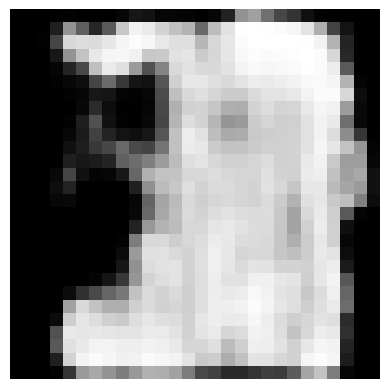

In [33]:
import matplotlib.pyplot as plt

# Sample a random latent vector and decode
z_sample = tf.random.normal(shape=(1, latent_dim))
generated = decoder(z_sample)[0].numpy().squeeze()

plt.imshow(generated, cmap='gray')
plt.axis('off')
plt.show()
